# Project 5: Ensemble Machine Learning - Wine Quality Prediction
**Author:** Adrianna Webb
**Date:** November 23, 2025
**Objective:** Predict wine quality categories (low, medium, high) using ensemble machine learning models to compare their performance and identify the most effective approach for classification.

## Introduction

This project explores ensemble machine learning models to predict wine quality using the Wine Quality Dataset from the UCI Machine Learning Repository. The dataset contains 1,599 samples of red wine with 11 physicochemical features (such as acidity, sugar content, alcohol percentage, and pH levels) that influence wine quality ratings.

Ensemble methods combine multiple models to improve predictive performance by reducing overfitting and improving generalization. I will evaluate and compare different ensemble approaches including Random Forest, AdaBoost, Gradient Boosting, Voting Classifiers, Bagging, and Neural Networks. The goal is to determine which ensemble technique provides the best accuracy and F1 score for classifying wines into quality categories.

In [28]:
# ------------------------------------------------
# Imports once at the top, organized
# ------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import (
    RandomForestClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier,
    BaggingClassifier,
    VotingClassifier,
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
)

## Section 1: Load and Inspect the Data

In [29]:
# Load the dataset
df = pd.read_csv("winequality-red.csv", sep=";")

# Display structure and first few rows
print("Dataset shape:", df.shape)
print("\nDataset info:")
df.info()
print("\nFirst few rows:")
df.head()

Dataset shape: (1599, 12)

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB

First few rows:


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


## Section 2: Prepare the Data

Transform the quality scores (0-10) into three categories to make classification more feasible:
- **Low quality**: scores 3-4
- **Medium quality**: scores 5-6  
- **High quality**: scores 7-8

Create both a text label and a numeric version for modeling.

In [30]:
# Define helper function to convert quality score to label
def quality_to_label(q):
    if q <= 4:
        return "low"
    elif q <= 6:
        return "medium"
    else:
        return "high"

# Create quality_label column (text labels)
df["quality_label"] = df["quality"].apply(quality_to_label)

# Define helper function to convert quality score to number
def quality_to_number(q):
    if q <= 4:
        return 0
    elif q <= 6:
        return 1
    else:
        return 2

# Create quality_numeric column (0 = low, 1 = medium, 2 = high)
df["quality_numeric"] = df["quality"].apply(quality_to_number)

# Check the distribution of quality categories
print("Quality distribution:")
print(df["quality_label"].value_counts())
print("\nSample of new columns:")
df[["quality", "quality_label", "quality_numeric"]].head(10)

Quality distribution:
quality_label
medium    1319
high       217
low         63
Name: count, dtype: int64

Sample of new columns:


,quality,quality_label,quality_numeric
0,5,medium,1
1,5,medium,1
2,5,medium,1
3,6,medium,1
4,5,medium,1
5,5,medium,1
6,5,medium,1
7,7,high,2
8,7,high,2
9,5,medium,1


## Section 3: Feature Selection and Justification

The dataset includes 11 physicochemical features that influence wine quality:
- **fixed acidity**: mostly tartaric acid
- **volatile acidity**: mostly acetic acid (vinegar)
- **citric acid**: adds freshness and flavor
- **residual sugar**: remaining sugar after fermentation
- **chlorides**: salt content
- **free sulfur dioxide**: protects wine from microbes
- **total sulfur dioxide**: sum of free and bound forms
- **density**: related to sugar content
- **pH**: acidity level (lower = more acidic)
- **sulphates**: antioxidant and microbial stabilizer
- **alcohol**: % alcohol by volume

Define X (features) as all physicochemical properties and y (target) as the numeric quality category.

In [31]:
# Define input features (X) and target (y)
# Features: all columns except quality, quality_label, and quality_numeric
X = df.drop(columns=["quality", "quality_label", "quality_numeric"])

# Target: quality_numeric (0=low, 1=medium, 2=high)
y = df["quality_numeric"]

print("Features shape:", X.shape)
print("Target shape:", y.shape)
print("\nFeature columns:")
print(X.columns.tolist())

Features shape: (1599, 11)
Target shape: (1599,)

Feature columns:
['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']


## Section 4: Split the Data into Train and Test

Split the data into 80% training and 20% test sets. Use stratification to preserve the class balance across both sets, ensuring each quality category is proportionally represented.

In [32]:
# Train/test split (stratify to preserve class balance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Training set size:", X_train.shape[0])
print("Test set size:", X_test.shape[0])
print("\nTraining set class distribution:")
print(y_train.value_counts().sort_index())
print("\nTest set class distribution:")
print(y_test.value_counts().sort_index())

Training set size: 1279
Test set size: 320

Training set class distribution:
quality_numeric
0      50
1    1055
2     174
Name: count, dtype: int64

Test set class distribution:
quality_numeric
0     13
1    264
2     43
Name: count, dtype: int64


## Section 5: Evaluate Model Performance

Evaluate two ensemble models: Random Forest and Gradient Boosting. Random Forest uses bagging (parallel training of multiple trees), while Gradient Boosting uses boosting (sequential training where each tree corrects previous errors).

Compare models using:
- **Accuracy**: proportion of correct predictions
- **Precision**: proportion of positive predictions that are correct
- **Recall**: proportion of actual positives correctly predicted
- **F1 Score**: harmonic mean of precision and recall

In [33]:
# Helper function to train and evaluate models
def evaluate_model(name, model, X_train, y_train, X_test, y_test, results):
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    train_f1 = f1_score(y_train, y_train_pred, average="weighted")
    test_f1 = f1_score(y_test, y_test_pred, average="weighted")
    
    print(f"\n{name} Results")
    print("Confusion Matrix (Test):")
    print(confusion_matrix(y_test, y_test_pred))
    print(f"Train Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}")
    print(f"Train F1 Score: {train_f1:.4f}, Test F1 Score: {test_f1:.4f}")
    
    results.append({
        "Model": name,
        "Train Accuracy": train_acc,
        "Test Accuracy": test_acc,
        "Train F1": train_f1,
        "Test F1": test_f1,
    })

# Initialize results list
results = []

In [34]:
# 1. Random Forest (100 trees)
evaluate_model(
    "Random Forest (100)",
    RandomForestClassifier(n_estimators=100, random_state=42),
    X_train,
    y_train,
    X_test,
    y_test,
    results,
)


Random Forest (100) Results
Confusion Matrix (Test):
[[  0  13   0]
 [  0 256   8]
 [  0  15  28]]
Train Accuracy: 1.0000, Test Accuracy: 0.8875
Train F1 Score: 1.0000, Test F1 Score: 0.8661


In [35]:
# 2. Gradient Boosting (100 trees)
evaluate_model(
    "Gradient Boosting (100)",
    GradientBoostingClassifier(
        n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42
    ),
    X_train,
    y_train,
    X_test,
    y_test,
    results,
)


Gradient Boosting (100) Results
Confusion Matrix (Test):
[[  0  13   0]
 [  3 247  14]
 [  0  16  27]]
Train Accuracy: 0.9601, Test Accuracy: 0.8562
Train F1 Score: 0.9584, Test F1 Score: 0.8411


## Section 6: Compare Results

In [36]:
# Create a DataFrame to compare results
results_df = pd.DataFrame(results)

# Calculate gaps between train and test
results_df["Accuracy Gap"] = results_df["Train Accuracy"] - results_df["Test Accuracy"]
results_df["F1 Gap"] = results_df["Train F1"] - results_df["Test F1"]

# Sort by test accuracy (descending)
results_df = results_df.sort_values("Test Accuracy", ascending=False)

print("Model Performance Comparison:")
print("="*80)
display(results_df)

print("\nKey Observations:")
print(f"Best Test Accuracy: {results_df.iloc[0]['Model']} with {results_df.iloc[0]['Test Accuracy']:.4f}")
print(f"Best Test F1 Score: {results_df.loc[results_df['Test F1'].idxmax(), 'Model']} with {results_df['Test F1'].max():.4f}")
print(f"Smallest Accuracy Gap: {results_df.loc[results_df['Accuracy Gap'].idxmin(), 'Model']} with {results_df['Accuracy Gap'].min():.4f}")

Model Performance Comparison:


,Model,Train Accuracy,Test Accuracy,Train F1,Test F1,Accuracy Gap,F1 Gap
0,Random Forest (100),1.000000,0.88750,1.00000,0.866056,0.112500,0.133944
1,Gradient Boosting (100),0.960125,0.85625,0.95841,0.841106,0.103875,0.117304



Key Observations:
Best Test Accuracy: Random Forest (100) with 0.8875
Best Test F1 Score: Random Forest (100) with 0.8661
Smallest Accuracy Gap: Gradient Boosting (100) with 0.1039


### 6.1 Visualize Model Comparison

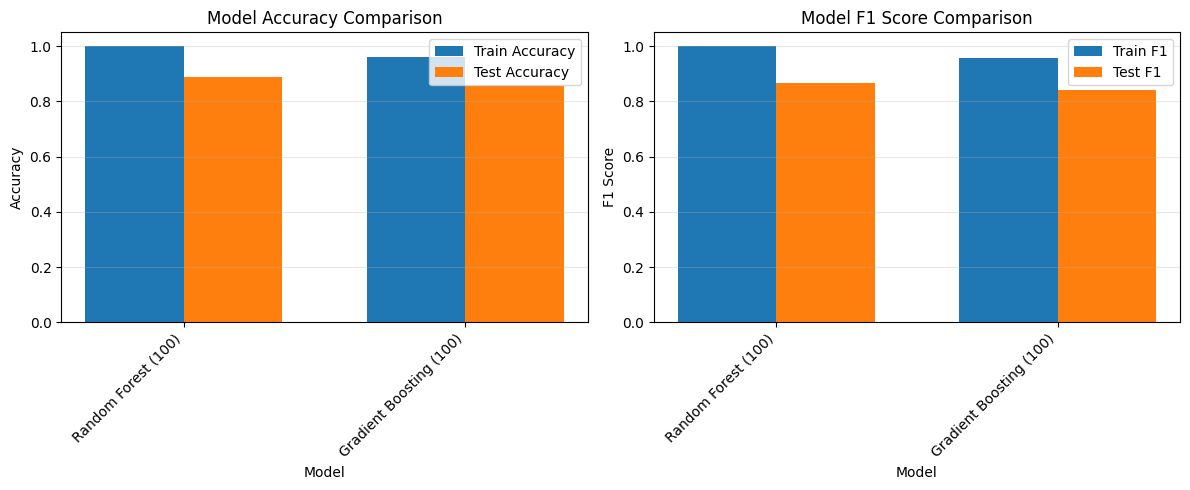

In [37]:
# Create comparison visualizations
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot 1: Accuracy Comparison
models = results_df["Model"]
x = np.arange(len(models))
width = 0.35

axes[0].bar(x - width/2, results_df["Train Accuracy"], width, label="Train Accuracy")
axes[0].bar(x + width/2, results_df["Test Accuracy"], width, label="Test Accuracy")
axes[0].set_xlabel("Model")
axes[0].set_ylabel("Accuracy")
axes[0].set_title("Model Accuracy Comparison")
axes[0].set_xticks(x)
axes[0].set_xticklabels(models, rotation=45, ha="right")
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Plot 2: F1 Score Comparison
axes[1].bar(x - width/2, results_df["Train F1"], width, label="Train F1")
axes[1].bar(x + width/2, results_df["Test F1"], width, label="Test F1")
axes[1].set_xlabel("Model")
axes[1].set_ylabel("F1 Score")
axes[1].set_title("Model F1 Score Comparison")
axes[1].set_xticks(x)
axes[1].set_xticklabels(models, rotation=45, ha="right")
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## Section 7: Conclusions and Insights

### Model Performance Analysis

Both ensemble models demonstrated strong performance in predicting wine quality categories, with test accuracies exceeding 85%.

**Random Forest (100 trees)**
- Achieved the highest test accuracy (88.75%) and F1 score (0.8661)
- Perfect training accuracy (100%) indicates some overfitting
- Accuracy gap of 0.1125 suggests the model memorized training patterns
- Strong performance likely due to averaging predictions across 100 independent trees

**Gradient Boosting (100 trees)**
- Test accuracy of 85.62% with F1 score of 0.8411
- Training accuracy of 96.01% shows better generalization
- Smallest accuracy gap (0.1039) indicates less overfitting than Random Forest
- Sequential error correction approach provides more balanced train/test performance

### Key Findings

1. **Best Overall Performance**: Random Forest achieved the highest test metrics
2. **Best Generalization**: Gradient Boosting showed smaller gaps between train and test performance
3. **Class Imbalance Impact**: Both models struggled with the "low" quality category (only 63 samples), as shown in confusion matrices
4. **Medium Quality Dominance**: The dataset contains 1,319 medium-quality wines, leading models to favor this category

### Recommendations for Model Improvement

If continuing this work in a competitive setting, consider:
- **Hyperparameter tuning**: Grid search for optimal max_depth, learning_rate, and n_estimators
- **Address class imbalance**: Use SMOTE or class weights to improve "low" and "high" category predictions
- **Feature engineering**: Create interaction terms between chemical properties
- **Cross-validation**: Use k-fold cross-validation for more robust performance estimates
- **Ensemble stacking**: Combine Random Forest and Gradient Boosting predictions
- **Try other boosting methods**: XGBoost or LightGBM may provide better performance

### Final Model Selection

For deployment, Random Forest (100) is recommended due to its superior test accuracy and F1 score. However, if model interpretability and reduced overfitting are priorities, Gradient Boosting provides a more balanced alternative with only slightly lower performance.